In [1]:
import os
import glob
import time
import itertools

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from scipy.ndimage.measurements import label

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


%matplotlib inline


##Explore HOG features

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Read in our vehicles and non-vehicles
cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features




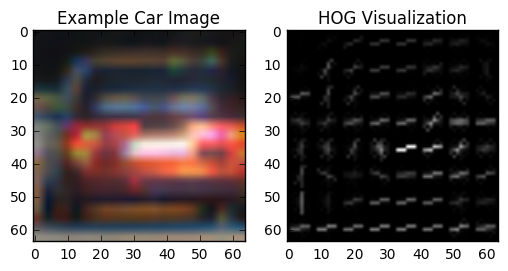

In [78]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

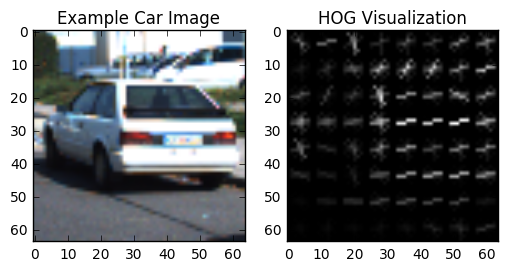

In [71]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 4
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

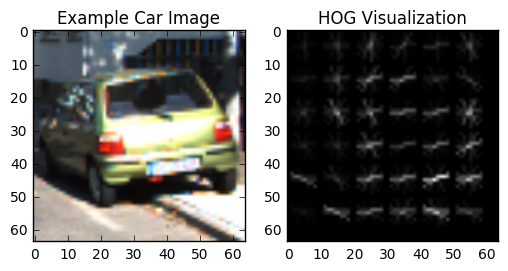

In [76]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 10
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

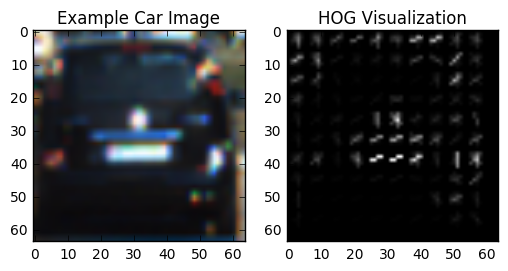

In [79]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 6
cell_per_block = 1
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

I tried various combinations of parameters. Plot out random Car image and its corresponding HOG visualization. I decide to use orient = 9, pix_per_cell = 8, cell_per_block = 2. I feel like these parameters best outline the shape of the car and has distinguishing grediant values.

In [3]:
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization

hog_desc = None

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

hog_desc = None

def init_hog(img_shape, orient=9, pix_per_cell=8, cell_per_block=2, reset=False):
    global hog_desc
    if hog_desc is None or reset:
        cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
        block_size = (cell_per_block, cell_per_block)  # h x w in cells
        nbins = orient  # number of orientation bins

        # winSize is the size of the image cropped to an multiple of the cell size
        hog_desc = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                          img_shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

    return hog_desc
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []

    hogd = None
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        if hogd is None:
            hogd = init_hog(image.shape, orient, pix_per_cell, cell_per_block, True)

        image = (image*255).astype(np.uint8)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
            #     hog_features = []
            #     for channel in range(feature_image.shape[2]):
            #         hog_features.append(get_hog_features(feature_image[:,:,channel],
            #                             orient, pix_per_cell, cell_per_block,
            #                             vis=False, feature_vec=True))
            #     hog_features = np.ravel(hog_features)
                hog_features = hogd.compute(feature_image)[:,0]
            else:
                hog_features = hogd.compute(feature_image[:,:,hog_channel])[:,0]
            #     hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
            #                 pix_per_cell, cell_per_block, vis=False, feature_vec=True)


            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

    


Feature extraction is done in the following:

In [4]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
cars = glob.iglob('data/vehicles/**/*.png')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcars = glob.iglob('data/non-vehicles/**/*.png')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

36.6 Seconds to extract features...


In [5]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [14]:
print(X_train.shape)

(14208, 2580)


I trained a linear SVM using spatial, histogram and hog features. The combined vector had a length of 2580.
It took 9.69 seconds to train. The model has an accuracy of 0.9868

In [6]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
9.69 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
0.004 Seconds to predict 10 labels with SVC


Save model and model configuration.

In [7]:
from sklearn.externals import joblib
config = dict(color_space=color_space, X_scaler=X_scaler,
            spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat)

model = 'models/linearSVC0301.pkl'

joblib.dump({'model':svc, 'config':config}, model)

['models/linearSVC0301.pkl']

In [8]:
model = 'models/linearSVC0301.pkl'
data = joblib.load(model)
# svc = data['model']
clf = data['model']
config = data['config']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']

print(config)

{'hist_bins': 16, 'hist_feat': True, 'hog_feat': True, 'cell_per_block': 2, 'pix_per_cell': 8, 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'spatial_size': (16, 16), 'orient': 9, 'spatial_feat': True, 'hog_channel': 0, 'color_space': 'YUV'}


In [9]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img_shape,  pyramid, x_start_stop=[None, None], xy_overlap=(0.5, 0.5)):
    
    window_list = []

    for xy_window, y_start_stop in pyramid:

        if xy_window is None:
            xy_window = (32, 32)
        if y_start_stop is None:
            y_start_stop = [None, None]
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img_shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img_shape[0]
        # Compute the span of the region to be searched
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan/nx_pix_per_step) - 1
        ny_windows = np.int(yspan/ny_pix_per_step) - 1
        # Initialize a list to append window positions to
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
    return window_list


In [114]:
image = mpimg.imread('test_images/test1.jpg')

pyramid = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 580]),
           ((192, 192),[450, None]),
      ]
image_size = (720, 1280)

windows = slide_window(image_size, pyramid, x_start_stop=[200, None], xy_overlap=(0.5, 0.5))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    


I decided to search the image region along y-axis 400-500 with 64x64 and 96x96 windows. For 450-580 along y-axis, I was using 128x128 windows. For 450+ along y-axis, I was using 192x192 windows.

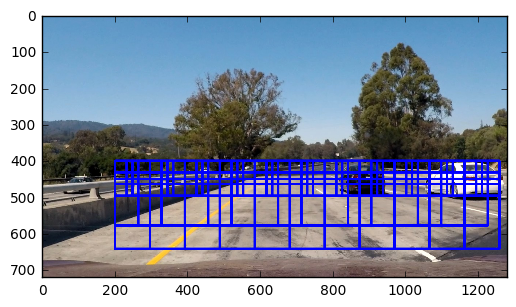

In [115]:
plt.imshow(window_img)

In [15]:
def init_hog(img_shape, orient=9, pix_per_cell=8, cell_per_block=2, reset=False):
    global hog_desc
    if hog_desc is None or reset:
        cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
        block_size = (cell_per_block, cell_per_block)  # h x w in cells
        nbins = orient  # number of orientation bins

        # winSize is the size of the image cropped to an multiple of the cell size
        hog_desc = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                          img_shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

    return hog_desc

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Define an empty list to receive features
    img_features = []

    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hogd = init_hog(img.shape, orient, pix_per_cell, cell_per_block, False)

        if hog_channel == 'ALL':
            hog_features = hogd.compute(feature_image)[:,0]
        else:
            hog_features = hogd.compute(feature_image[:,:,hog_channel])[:,0]
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, X_scaler, color_space='RGB',
                    spatial_size=None, hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True, dec_threshold=0.75):

    if spatial_size is None:
        spatial_size = (32, 32)

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    all_features = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        #test_features = np.array(features).reshape(1, -1)
        test_features = X_scaler.transform(np.array((features)).reshape(1, -1))

        #6) Predict using your classifier
        dec = clf.decision_function(test_features)
        prediction = int(dec > dec_threshold)

        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

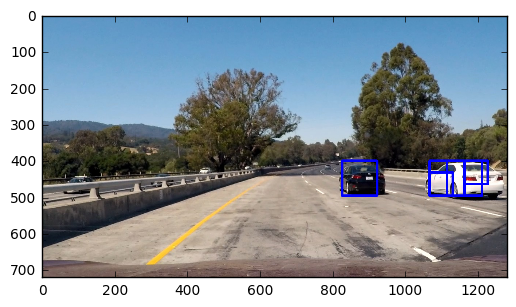

In [37]:
image = mpimg.imread('test_images/test1.jpg')

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
X_scaler = config['X_scaler']
hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space,
                    spatial_size=spatial_size, hist_bins=hist_bins,
                    orient=orient, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                    hist_feat=hist_feat, hog_feat=hog_feat)
draw_image = np.copy(image)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)



In [38]:
def update_heatmap(hot_windows, image_shape, heatmap = None):
    if heatmap is None:
        heatmap = np.zeros((image_shape[0], image_shape[1]), np.uint8)

    for pt1, pt2 in hot_windows:
        x1, y1 = pt1
        x2, y2 = pt2
        x1 = min(max(x1, 0), image_shape[1])
        x2 = min(max(x2, 0), image_shape[1])
        y1 = min(max(y1, 0), image_shape[0])
        y2 = min(max(y2, 0), image_shape[0])
        xv, yv = np.meshgrid(range(x1, x2), range(y1, y2))

        heatmap[yv, xv] += 1

    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [39]:
params = {}
params['heatmap_threshold'] = 1
heatmap = update_heatmap(hot_windows, image.shape)
thresh_heatmap = heatmap
thresh_heatmap[heatmap < params['heatmap_threshold']] = 0
cv2.GaussianBlur(thresh_heatmap, (31,31), 0, dst=thresh_heatmap)

labels = label(thresh_heatmap)
im2 = draw_labeled_bboxes(np.copy(image), labels)


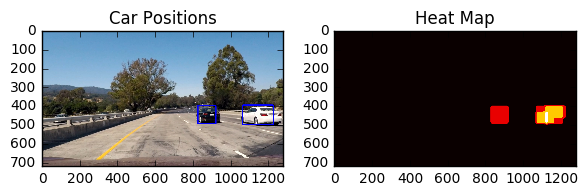

In [40]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(im2)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(thresh_heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

Construct video process pipeline

In [75]:
def process_image(image, params):
    config, clf, all_windows = params['clf_config'], params['clf'], params['windows']

    if params['cache_enabled']:
        cache = process_image.cache
        if cache['heatmaps'] is None:
            cache['heatmaps'] = collections.deque(maxlen=params['heatmap_cache_length'])


    color_space = config['color_space']
    spatial_size = config['spatial_size']
    hist_bins = config['hist_bins']
    orient = config['orient']
    pix_per_cell = config['pix_per_cell']
    cell_per_block = config['cell_per_block']
    hog_channel = config['hog_channel']
    spatial_feat = config['spatial_feat']
    hist_feat = config['hist_feat']
    hog_feat = config['hog_feat']
    X_scaler = config['X_scaler']

    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    draw_image = np.copy(image)
    current_heatmap = update_heatmap(hot_windows, image.shape)
    if not params['cache_enabled']:
        thresh_heatmap = current_heatmap
    else:
        cache['heatmaps'].append(current_heatmap)
        thresh_heatmap = sum(cache['heatmaps'])
    
    thresh_heatmap[thresh_heatmap < params['heatmap_threshold']] = 0
    cv2.GaussianBlur(thresh_heatmap, (31,31), 0, dst=thresh_heatmap)

    labels = label(thresh_heatmap)
    im2 = draw_labeled_bboxes(np.copy(image), labels)

        
    return im2

def clear_cache():
    process_image.cache = {
        'heatmaps': None,
    }
    

Run test on images

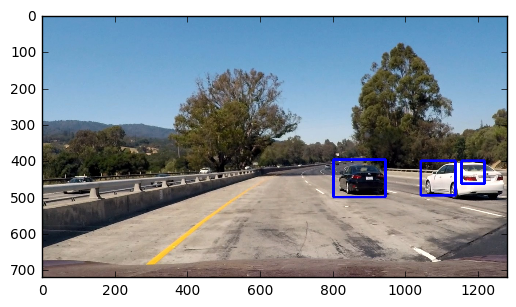

In [100]:
pyramid = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 600]),
           ((192, 192),[450, None]),
      ]
image_size = (720, 1280)
windows = slide_window(image_size, pyramid, x_start_stop=[200, None], xy_overlap=(0.5, 0.5))

clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 10
params['heatmap_threshold'] = 1

image = mpimg.imread('test_images/test1.jpg')
im2 = process_image(image, params)
plt.imshow(im2)

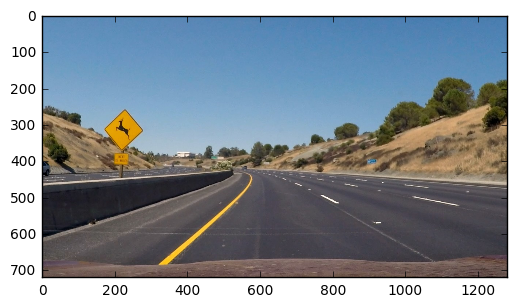

In [65]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 10
params['heatmap_threshold'] = 1
image = mpimg.imread('test_images/test2.jpg')
im2 = process_image(image, params)
plt.imshow(im2)

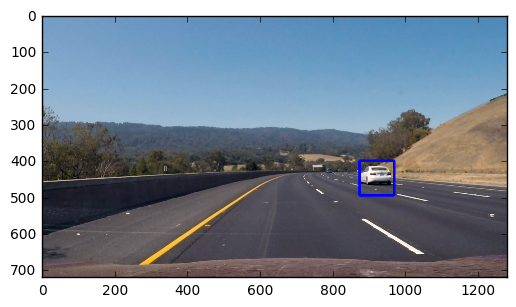

In [66]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 10
params['heatmap_threshold'] = 1
image = mpimg.imread('test_images/test3.jpg')
im2 = process_image(image, params)
plt.imshow(im2)

A short video to test on.

In [69]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 25
params['heatmap_threshold'] = 1

vid_output = 'output/test_video_out.mp4'
clip = VideoFileClip('test_video.mp4')
vid_clip = clip.fl_image(lambda x: process_image(x, params))
#vid_clip = clip.fl_image(process_image)

vid_clip.write_videofile(vid_output, audio=False)


[MoviePy] >>>> Building video output/test_video_out.mp4
[MoviePy] Writing video output/test_video_out.mp4


 97%|█████████▋| 38/39 [00:05<00:00,  6.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/test_video_out.mp4 



In [70]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

Full project video

In [125]:

windows = slide_window(image_size, pyramid, x_start_stop=[600, None], xy_overlap=(0.7, 0.7))

clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 15
params['heatmap_threshold'] = 7

vid_output = 'output/project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
vid_clip = clip.fl_image(lambda x: process_image(x, params))
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video output/project_video_out.mp4
[MoviePy] Writing video output/project_video_out.mp4



100%|█████████▉| 1260/1261 [09:06<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video_out.mp4 



In [126]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

Discussion

There is more noises and false positives in video frames. To solve this, I increased the overlap areas of each window. It results in more subsampling windows, hence increase computation time. I also tried different combinations of heatmap threshold and cache sizes.

In the future, if I would spend more time on this project. I would like to try kalman filter. I found some paper about detection techniques using kalman filters. I would also like to try integrate YOLO into my pipeline in the future. (https://pjreddie.com/darknet/yolo/)